# Binomial Test

> Use Case
- Used when dealing with a dichotomous outcome (success/failure) and comparing the proportion of successes between two groups.
- Useful when the sample size is small.
- Can have different sample sizes.
> Assumptions
- The data must be binary (success/failure).
- Each observation must be independent.
> Example Scenario
- Testing whether the click-through rate (CTR) for a new ad campaign is different from the historical CTR (historical success rate).
> Null Hypothesis (H0):
- There is no difference in proportions
- The click-through rate for the new ad campaign is equal to the historical CTR.
> Alternative Hypothesis (H1):
- There is a significant difference in proportions
- The click-through rate for the new ad campaign is different from the historical CTR.

In [242]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# !pip install scipy==1.12.0
from scipy.stats import binomtest, norm, binom

# !pip install statsmodels==0.12.2
from statsmodels.stats.proportion import binom_test

# !pip install pingouin==0.5.4
from pingouin import bayesfactor_binom

In [243]:
import statsmodels
statsmodels.__version__

'0.12.2'

In [244]:
import scipy
scipy.__version__

'1.12.0'

In [245]:
# Set random seed for reproducibility
np.random.seed(42)

In [246]:
# set seaborn style
sns.set(style="white", palette="mako")

# colors
color = 'tomato'

# remove some borders    
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

### Power Analysis

In [247]:
# Historical click-through rate
historical_ctr = 0.14

In [267]:

def plot_power_binom(p1, k=1, confidence_level=0.95, power=0.8):
    '''
    Reference: 
        The calculations are the customary ones based on the normal approximation to the binomial distribution. 
        See for example Hypothesis Testing: Categorical Data - Estimation of Sample Size and Power for Comparing Two Binomial Proportions 
        in Bernard Rosner's Fundamentals of Biostatistics
    
    About:
        Plots the varying number of samples needed to run a Binomial Test for two groups with different number of samples for each group

    Arguments:
        p1:(float) = The proportion of successes from Group A 
        k:(float) = The ratio of samples for Group B compared to Group A (if 2 then Group B requires twice as many samples)
        confidence_level:(float) = A value between 0.0 and 1.0 for the confidence level (1-alpha) or False Positive Rate
        power:(float) = A value between 0.0 and 1.0 for the statistical power of the test or the True Positive Rate
    
    Outputs:
        A plot of samples sizes needed per varying differences in proportions
    '''
    # The propotion of failures for group A
    q1 = 1 - p1
    # An array of posssible propotion of successes in Group B
    p2 = np.array([p for p in np.linspace(0.01, 1, 10) + p1 if p < 1 ])
    # The propotion of failures for group B
    q2 = 1 - p2
    # The average of propotions of successes between the two groups
    p_avg = ((p1 + p2)/2)
    # The avgerage propotion of failures between the two groups
    q_avg = 1 - p_avg
    # The two-tailed z-score for the confidence level
    z_alpha = norm.ppf(1 - (1 - confidence_level) / 2)
    # The one-tailed z-score for the power
    z_beta = norm.ppf(1 - (1 - power) )
    # The difference in proportions
    delta = p2 - p1
    # An array of sample sizes for group A
    n1 = (((np.sqrt((p_avg * q_avg * (1 + (1/k)))) * z_alpha) + ((np.sqrt((p1*q1) + ((p2*q2) / k))) * z_beta))**2) / (delta**2)
    # An array of sample sizes for group B
    n2 = n1 * k

    # Figure size
    plt.figure(figsize=(12, 4))
    # Plot samples versus effect sizes
    plt.plot(delta, n1, color=color, marker='o', label = "Group A")
    # Shade area below the line with lower opacity
    plt.fill_between(delta, n1, color=color, alpha=0.3)
    # Plot samples versus effect sizes
    plt.plot(delta, n2, color='lightblue', marker='o', label = "Group B")
    # Shade area below the line with lower opacity
    plt.fill_between(delta, n2, color='lightblue', alpha=0.3)
    # Add plot labels and title
    plt.xlabel('Anticipated Difference in Proportions')
    plt.ylabel('Number of Samples')
    plt.title('Samples versus Anticipated Difference in Proportions Binomial Test')
    plt.legend()
    plt.show()

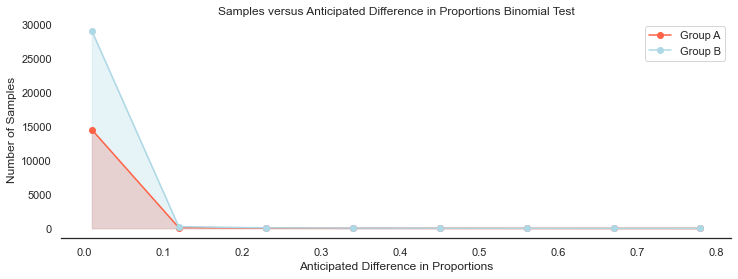

In [268]:
# the confidence level (1-alpha) or False Positive Rate
confidence_level = 0.95
# the statistical power of the test or the True Positive Rate
power = 0.8
# the historical proportion of group A
p1 = historical_ctr
# how many times more samples for group B
k = 2

plot_power_binom(p1 = historical_ctr, k=k, confidence_level=confidence_level, power=power)

In [250]:
def power_binom(p1, p2, k=1, confidence_level=0.95, power=0.8):
    '''
    Reference: 
        The calculations are the customary ones based on the normal approximation to the binomial distribution. 
        See for example Hypothesis Testing: Categorical Data - Estimation of Sample Size and Power for Comparing Two Binomial Proportions 
        in Bernard Rosner's Fundamentals of Biostatistics
    
    About:
        Estimates number of samples needed to run a Binomial Test for two groups with different number of samples for each group

    Arguments:
        p1:(float) = The proportion of successes from Group A 
        p2:(float) = The estimated proportion of successes from Group B
        k:(float) = The ratio of samples for Group B compared to Group A (if 2 then Group B requires twice as many samples)
        confidence_level:(float) = A value between 0.0 and 1.0 for the confidence level (1-alpha) or False Positive Rate
        power:(float) = A value between 0.0 and 1.0 for the statistical power of the test or the True Positive Rate
    
    Outputs:
        n1:(int) = The number of samples required for Group A
        n2:(int) = The number of samples required for Group B
    '''
    # The propotion of failures for group A
    q1 = 1 - p1
    # The propotion of failures for group B
    q2 = 1 - p2
    # The average of propotions of successes between the two groups
    p_avg = ((p1 + p2)/2)
    # The avgerage propotion of failures between the two groups
    q_avg = 1 - p_avg
    # The two-tailed z-score for the confidence level
    z_alpha = norm.ppf(1 - (1 - confidence_level)/ 2)
    # The one-tailed z-score for the power
    z_beta = norm.ppf(power)
    # The difference in proportions
    delta = p1 - p2
    # Sample size for group A
    n1 = int(np.ceil((((np.sqrt((p_avg * q_avg * (1 + (1/k)))) * z_alpha) + ((np.sqrt((p1*q1) + ((p2*q2) / k))) * z_beta))**2) / (delta**2)))
    # Sample size for group B
    n2 = int(np.ceil(n1 * k))

    print(f"Samples size for Group A: {n1}")
    print(f"Samples size for Group B: {n2}")

    return n1, n2

In [251]:
# the confidence level (1-alpha) or False Positive Rate
confidence_level = 0.95
# the statistical power of the test or the True Positive Rate
power = 0.8
# the historical proportion of group A
p1 = historical_ctr
# the anticipated proportion of group B
p2 = 0.2
# how many times more samples for group B
k = 2

n1, n2 = power_binom(p1, p2, k=k, confidence_level=0.95, power=0.8)

Samples size for Group A: 455
Samples size for Group B: 910


### Synthetic Data

In [252]:
n_trials = n2

# Generate synthetic data for new ad campaign
# Assuming a slightly higher CTR for the new campaign
new_ad_campaign = np.random.binomial(n=1, p=0.18, size=n1)  
hist_ad_campaign = np.random.binomial(n=1, p=historical_ctr, size=n2)

# Ensure the lists are of the same size
max_len = max(len(new_ad_campaign), len(hist_ad_campaign))
new_ad_campaign = np.append(new_ad_campaign, [np.nan] * (max_len - len(new_ad_campaign)))
hist_ad_campaign = np.append(hist_ad_campaign, [np.nan] * (max_len - len(hist_ad_campaign)))


# Create pandas data frame
binomial_data = pd.DataFrame({'Historical_CTR': hist_ad_campaign,
                            'New_Ad_Campaign': new_ad_campaign})

binomial_data = binomial_data.astype("Int64")
binomial_data

,Historical_CTR,New_Ad_Campaign
0,0,0
1,0,1
2,0,0
3,0,0
4,0,0
...,...,...
905,1,<NA>
906,0,<NA>
907,0,<NA>
908,0,<NA>


### Check Assumptions

In [253]:
# Assumption check for binomial test
min_successes = 5
min_failures = 5

# Check if there are enough successes and failures
successes_check = (binomial_data['New_Ad_Campaign'].sum() >= min_successes)
failures_check = ((n_trials - binomial_data['New_Ad_Campaign'].sum()) >= min_failures)

# Check if the data is binary
binary_new_check = (binomial_data['New_Ad_Campaign'].isin([0, 1, np.nan, pd.NA]).all())
binary_historical_check = (binomial_data['Historical_CTR'].isin([0, 1, np.nan, pd.NA]).all())

print(f"Binomial Test Assumption: At least {min_successes} successes and {min_failures} failures - {'Met' if successes_check and failures_check else 'Not Met'}")
print(f"Binomial Test Assumption: Data is numeric and binary - {'Met' if binary_new_check and binary_historical_check else 'Not Met'}")


Binomial Test Assumption: At least 5 successes and 5 failures - Met
Binomial Test Assumption: Data is numeric and binary - Met


### Binomial Test (scipy)

In [254]:
# Pre-determined alpha
alpha = 0.05

In [255]:
# Assuming binomial test assumptions are met

# Binomial test
result = binomtest(binomial_data['New_Ad_Campaign'].sum(), n_trials, p=historical_ctr)

# p-value
p_value = result.pvalue

print(f"P-value for Binomial Test: {p_value}")

# Check for statistical significance
if p_value < alpha:
    conclusion = "Reject the null hypothesis."
    interpretation = "The click-through rate for the new ad campaign is significantly different from the historical CTR."
else:
    conclusion = "Fail to reject the null hypothesis."
    interpretation = "There is no significant difference in click-through rates between the new ad campaign and historical CTR."
print("\n")
print(conclusion)
print(interpretation)

P-value for Binomial Test: 2.072541580973687e-06


Reject the null hypothesis.
The click-through rate for the new ad campaign is significantly different from the historical CTR.


### Binomial Test (statsmodels)

In [256]:
# Pre-determined alpha
alpha = 0.05

In [257]:
count = binomial_data['New_Ad_Campaign'].sum()
nobs = len(binomial_data['New_Ad_Campaign'])

binom_test(count =count, nobs=nobs, prop=historical_ctr, alternative='two-sided')

AttributeError: module 'scipy.stats' has no attribute 'binom_test'

# Binomial Test - Bayes Factor (pingouin)

In [278]:
# The number of successes
k = int(binomial_data['New_Ad_Campaign'].sum())
# The number of trials
n = int(binomial_data['New_Ad_Campaign'].count())
# The historical probability
p = historical_ctr
# The alpha shape parameter of the Beta Distribution (a=a and b=1 is an uninformed prior)
a = 1
# The beta shape parameter of the Beta Distribution (a=a and b=1 is an uninformed prior)
b = 1 

# Evaluate Bayes Factor
bf = bayesfactor_binom(k=k, n=n, p=p, a=a, b=b)

print(f"Bayes Factor of the Alternative Hypothesis: {round(bf, 4)}")
print(f"Bayes Factor of the Null Hypothesis: {round(1/bf, 4)}")
print("\n")
if bf > (1/bf):
    print("There is more evidence to support the Alternative Hypothesis than the Null Hypothesis")
else:
    print("There is more evidence to support the Null Hypothesis than the Alternative Hypothesis")
if bf < 1/10:
    print("There is strong evidence for the Null Hypothesis, there is absolutely no difference in proportions")
elif bf < 1:
    print("There is weak evidence for the Null Hypothesis, there probably is no difference in proportions")
elif bf < 10:
    print("There is weak evidence for the Alternative Hypothesis, there is a probably a significant difference in proportions")
else:
    print("There is strong evidence for the Alternative Hypothesis, there is absolutely a significant difference in proportions")

Bayes Factor of the Alternative Hypothesis: 0.4332
Bayes Factor of the Null Hypothesis: 2.3082


There is more evidence to support the Null Hypothesis than the Alternative Hypothesis
There is weak evidence for the Null Hypothesis, there probably is no difference in proportions


### Summary Table

In [279]:
# Count everything up
total_count = binomial_data.size
group_a_count = binomial_data['New_Ad_Campaign'].count()
group_b_count = binomial_data['Historical_CTR'].count()

group_a_positive_count = binomial_data['New_Ad_Campaign'].sum()
group_a_negative_count = group_a_count - group_a_positive_count

group_b_positive_count = binomial_data['Historical_CTR'].sum()
group_b_negative_count = group_b_count - group_b_positive_count

group_a_proportion = group_a_positive_count/group_a_count

group_b_proportion = group_b_positive_count/group_b_count

In [280]:
# Create a new DataFrame for plotting
plot_data = pd.DataFrame({
    'Test Group': ["Group A: New Ad Campaign", "Group B: Historical CTR"],
    'Total': [group_a_count, group_b_count],
    'Click': [group_a_positive_count, group_b_positive_count],
    'No Click': [group_a_negative_count, group_b_negative_count],
    'Click Through Rate': [group_a_proportion, group_b_proportion],
}, index=[0, 1])
plot_data

,Test Group,Total,Click,No Click,Click Through Rate
0,Group A: New Ad Campaign,455,80,375,0.175824
1,Group B: Historical CTR,910,145,765,0.159341


### 95% Confidence Interval

In [281]:
# Confidence interval
confidence_interval = 0.95

# Proportions
prop_A = group_a_positive_count / group_a_count
prop_B = group_b_positive_count / group_b_count

# Standard errors
se_A = np.sqrt(prop_A * (1 - prop_A) / group_a_count)
se_B = np.sqrt(prop_B * (1 - prop_B) / group_b_count)

# Difference in proportions
prop_diff = prop_A - prop_B

# Standard error of the difference
se_diff = np.sqrt(se_A**2 + se_B**2)

# Z-score for confidence interval (two-tailed)
z_score = norm.ppf(confidence_interval)

# Margin of error
margin_of_error = z_score * se_diff

# Confidence interval
lower_ci = prop_diff - margin_of_error
upper_ci = prop_diff + margin_of_error

print(f"Difference in Proportions: {prop_diff}")
print(f"95% Confidence Interval of Difference in Proportions: [{lower_ci}, {upper_ci}]")

Difference in Proportions: 0.016483516483516508
95% Confidence Interval of Difference in Proportions: [-0.0190119037835845, 0.051978936750617516]


### Effect Size

In [282]:
# Cohen's h effect size
h = np.arcsin(np.sqrt(prop_A)) - np.arcsin(np.sqrt(prop_B))

print(f"Cohen's h Effect Size: {h}")
print("\n")

if abs(h) == 0:
    print("There is no difference between the two groups.")
elif abs(h) <= 0.2:
    print("There is a small difference between the two groups.")
elif abs(h) <= 0.5:
    print("There is a moderate difference between the two groups.")
elif abs(h) <= 0.8:
    print("There is a large difference between the two groups.")
else:
    print("There is a very large difference between the two groups.")

Cohen's h Effect Size: 0.02207263262511383


There is a small difference between the two groups.


### Visualization

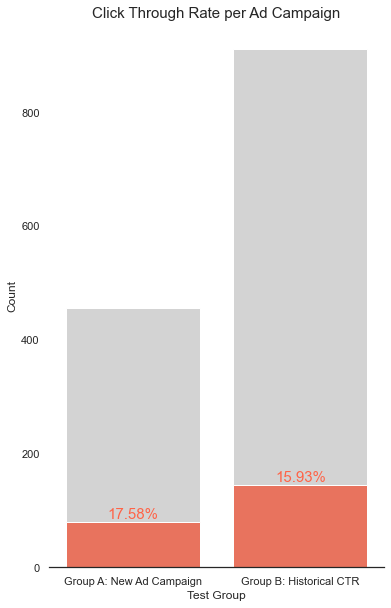

In [291]:
# Plot stacked bars
plt.figure(figsize=(6, 10))

plot_total = sns.barplot(x=plot_data['Test Group'], 
                        y=plot_data['Total'], color='lightgrey')

plot_satisfied = sns.barplot(x=plot_data['Test Group'], 
                            y=plot_data['Click'], color=color)

# Set labels and title
plt.title('Click Through Rate per Ad Campaign', fontsize=15)
plt.ylabel('Count')
plt.tick_params(left=False,bottom=False,labelleft=True,labelbottom=True)

# Put values on top of bars
row_list = []
for index, row in plot_data[plot_data['Test Group'] == 'Group A: New Ad Campaign'][['Click', 'Click Through Rate']].iterrows():
    plot_total.text(row.name, row['Click']+5, str(round(100 * row['Click Through Rate'], 2)) + '%', color=color, ha="center", fontsize=15)
for index, row in plot_data[plot_data['Test Group'] == 'Group B: Historical CTR'][['Click', 'Click Through Rate']].iterrows():
    plot_satisfied.text(row.name, row['Click']+5, str(round(100 * row['Click Through Rate'], 2)) + '%', color=color, ha="center", fontsize=15)


# Show the plot
plt.show()